# Visão Computacional com Aprendizado Profundo

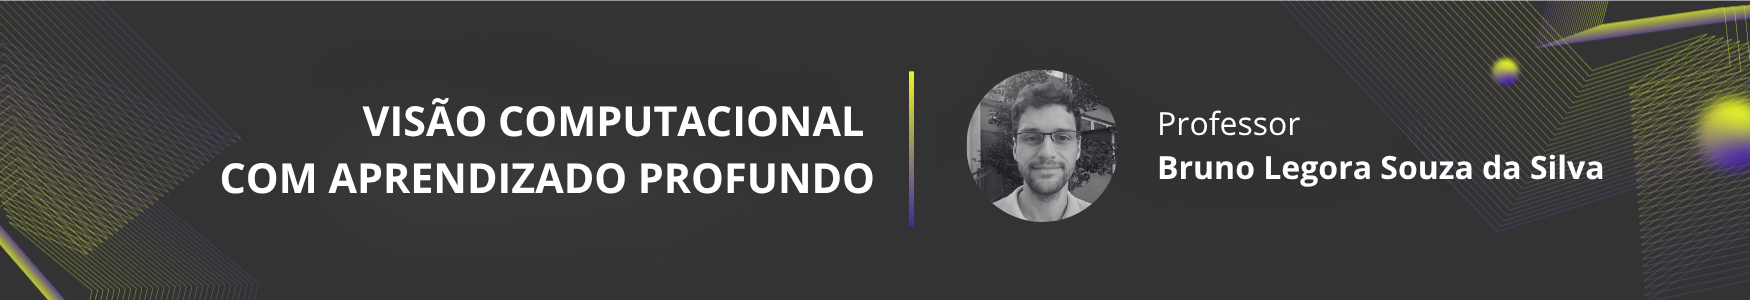

# Laboratório 8 - Treinando com Padronização de Resoluções

Neste laboratório, vamos rever o Laboratório 07, mas agora padronizando as resoluções das imagens e comparando o treinamento da U-net


## Revisão - Lab 7 (U-net)

No Laboratório 7, treinamos uma U-net com uma base de dados de segmentação de animais. Ao final do laboratório, vimos que o resultado não foi tão satisfatório. A rede neural apenas jogava 1 em todos os pixels de saída.

Recapitulando os resultados:

Imagem original:

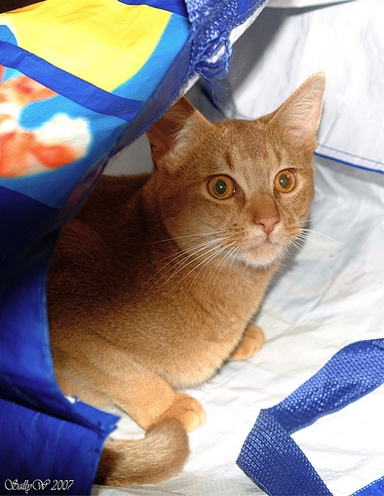


Imagem "alvo":

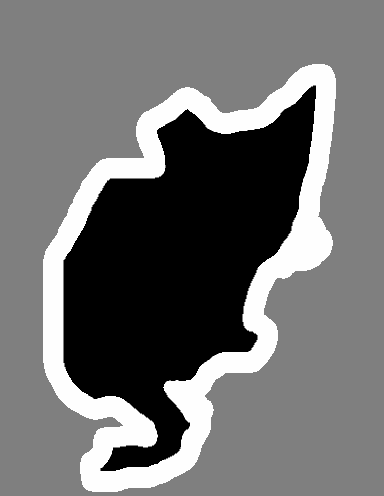

Saída da rede neural:

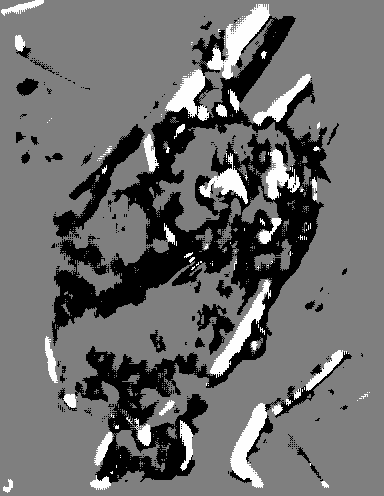

Neste laboratório, iremos retreinar essa rede nessa mesma base de dados, mas usando uma das técnicas que "melhoram" o treinamento da rede neural: o redimensionamento das imagens.

Vimos que imagens de tamanhos diferentes trazia um problema para o treinamento da rede neural, causando muita instabilidade no processo de treinamento, e consequentemente, resultados ruins.

Redefinindo a U-net (igual feito no Lab 7)

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import torch
import torchvision

# Neste laboratório, veremos outra forma de definir redes neurais usando Pytorch
# É possível construir usando apenas a forma Sequential, mas o código ficaria longo

# Como temos muitas repetições de blocos iguais, iremos estender a classe torch.nn.Module,
# criando nosso próprio módulo (subrede)!

# O código abaixo cria um módulo básico de nome "BlocoEncoder" com dois parâmetros configuráveis
# no construtor (método __init__(...)) - num_canais_entrada e num_canais_saida;

# Variáveis locais são criadas e o método "forward" é definido descrevendo como que uma entrada
# x percorre pela rede até ela saida - basicamente passando por todas as camadas.

class BlocoEncoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)
        self.layer5 = torch.nn.MaxPool2d(2)

    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.layer5(x)
      return x

# Da mesma forma, o BlocoDecoder é criado. Mas aqui há algumas diferenças, principalmente no método forward.
# O __init__ também define as camadas, mas o método forward é responsável por concatenar a saída da camada de
# convolução transposta com a skip_connection que ela recebe. Reparem que a skip connection é um parâmetro do
# método forward!
# A saída do upscale é concatenado com a skip connection. Porém, a operação de "copy and crop" deve ser feita para
# que os tamanhos sejam os mesmos. Para isso, usaremos o método torchvision.transforms.Resize para
# redimensionar a skip_connection de forma que ela tenha o mesmo tamanho da saída do upscale (x.size())

# Reparem na imagem acima que o resultado da concatenação da saída do bloco de upconv com a skip_connection
# possui o mesmo número de canais do bloco imediatamente anterior. Isso significa que o upconv diminui a
# quantidade de canais pela metade, e esse tensor com metade dos canais (N/2) é concatenado com um tensor de mesmo
# tamanho para que os N canais sejam mantidos na saída da operação da skip connection.
# Ex: O bloco superior à direita possui 128 canais na entrada, e a upconv possui 64 canais. Esses 64 canais
# são concatenados com os 64 canais da skip connection, formando os 128 canais "do inicio do bloco".

class BlocoDecoder(torch.nn.Module):

    def __init__(self, num_canais_entrada, num_canais_saida, padding='valid'):
        super().__init__()
        # upconv diminui o numero de canais pela metade!
        self.up = torch.nn.ConvTranspose2d(num_canais_entrada, num_canais_entrada // 2, kernel_size=2, stride=2)
        self.layer1 = torch.nn.Conv2d(num_canais_entrada, num_canais_saida, kernel_size=3, padding=padding)
        self.layer2 = torch.nn.ReLU(inplace=True)
        self.layer3 = torch.nn.Conv2d(num_canais_saida, num_canais_saida, kernel_size=3, padding=padding)
        self.layer4 = torch.nn.ReLU(inplace=True)

    def forward(self, x, skip_connection):
      x = self.up(x)
      skip_connection = torchvision.transforms.Resize((x.size()[2],x.size()[3]))(skip_connection)
      x = torch.cat([skip_connection, x], dim=1)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      return x

# Obs: Poderíamos construir os módulos da seguinte forma
# num_canais_entrada_bloco1 = 1
# num_canais_saida_bloco1 = 64
# encoder1 = torch.nn.Sequential(
#     torch.nn.Conv2d(num_canais_entrada_bloco1, num_canais_saida_bloco1, kernel_size=3, padding='valid'),
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Conv2d(num_canais_saida_bloco1, num_canais_saida_bloco1, kernel_size=3, padding='valid')
#     torch.nn.ReLU(inplace=True),
#     torch.nn.MaxPool2d(2)
# )
# num_canais_entrada_bloco2 = 64
# num_canais_saida_bloco2 = 128
# encoder1 = torch.nn.Sequential(
#     torch.nn.Conv2d(num_canais_entrada_bloco2, num_canais_saida_bloco2, kernel_size=3, padding='valid'),
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Conv2d(num_canais_saida_bloco2, num_canais_saida_bloco2, kernel_size=3, padding='valid')
#     torch.nn.ReLU(inplace=True),
#     torch.nn.MaxPool2d(2)
# )

# E assim sucessivamente... Ou ainda construirmos a U-net diretamente. Mas daí ficam duas questões:
# Muito código copiado!!!
# Como faríamos as skip connections?



Definidos os dois tipos de blocos, podemos começar a construir nossa rede neural U-Net, do jeito que ela foi projetada!



In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes, padding='valid'):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.encoder1 = BlocoEncoder(n_channels,64,padding=padding)
        self.encoder2 = BlocoEncoder(64,128,padding=padding)
        self.encoder3 = BlocoEncoder(128,256,padding=padding)
        self.encoder4 = BlocoEncoder(256,512,padding=padding)
        self.base1 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding=padding)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.base2 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=padding)
        self.relu2 =  torch.nn.ReLU(inplace=True)
        self.decoder1 = BlocoDecoder(1024,512,padding=padding)
        self.decoder2 = BlocoDecoder(512,256,padding=padding)
        self.decoder3 = BlocoDecoder(256,128,padding=padding)
        self.decoder4 = BlocoDecoder(128,64,padding=padding)
        self.conv1 = torch.nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x = self.base1(x4)
        x = self.relu1(x)
        x = self.base2(x)
        x = self.relu2(x)
        x = self.decoder1(x,x4) # skip connection aqui!
        x = self.decoder2(x,x3) # skip connection aqui!
        x = self.decoder3(x,x2) # skip connection aqui!
        x = self.decoder4(x,x1) # skip connection aqui!
        x = self.conv1(x)
        return x

# Podemos criar uma U-Net com 3 canais de entrada e 2 classes da seguinte forma:
unet = UNet(3,2)

Construída a rede, vamos carregar os dados:

In [ ]:
# Carregando o dataset:

import os
working_dir = "."

pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
# pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)



100%|██████████| 792M/792M [00:35<00:00, 22.4MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 12.3MB/s]


Após baixar, temos 3680 imagens de treino/validação e 3669 de teste!

## Redimensionamento da Base de Dados

Vimos no Lab. 7 que a base de dados é grande para carregarmos toda de uma vez. Se usarmos cerca de 50% da base, usamos quase toda a memória do Colab. Vamos usar cerca de 10% da base (~368 imagens) no treinamento.

Outro problema encontrado é o da resolução da base de dados, como citado acima. Para resolver esse problema, vamos redimensionar a base de dados.

Neste ponto, devemos aplicar uma das técnicas de redimensionamento de imagens:

- Redimensionando todas para um tamanho fixo
- Criar bordas nas imagens menores que a de maior resolução.

Vamos fazer o caso mais simples nesse laboratório - redimensionar todas para o mesmo tamanho. Mas qual tamanho? Podemos escolher a resolução da maior imagem, ou da menor... Ou qualquer valor!

<!-- Vamos escolher, aqui, a resolução que tem a mediana das áreas. Isto é, metade das imagens tem mais pixels que essa resolução, e metade tem menos pixels!

Teoricamente, iremos aumentar a resolução de metade das imagens, e diminuir da outra metade. -->

Por motivos de velocidade, vamos escolher a melhor resolução (menor resolução = menos custo computacional = treino mais rapido!)

A célula abaixo encontra a resolução "mínima" do conjunto:

In [ ]:
percentage = 10
areas = []
resolucoes = []

for i in range(len(pets_train_orig)//(100//percentage)):
  x = pets_train_orig[i][0]
  areas.append(x.size[0]*x.size[1])
  resolucoes.append(x.size)

x=np.min(areas)
idx = areas.index(x)
resolucao_target = resolucoes[idx]
print(resolucao_target)


(114, 143)


Abaixo, repetiremos o código do Lab. 7. Nele, redimensionávamos a imagem para que o tamanho dela seja o múltiplo de 16 mais próximo da resolução original. Agora, redimensionamos todas as imagens para o múltiplo de 16 mais próximo da resolução target.

Lembrando: isso vale tanto para a imagem original quanto para o "target" - ambos devem ser redimensionados.

In [ ]:
def arredondaMultiplo16(num):
  return (num // 16) * 16;

def pilToResizedTensor(x,res_target=None):
  if (res_target != None):
    new_sz1 = arredondaMultiplo16(res_target[0])
    new_sz2 = arredondaMultiplo16(res_target[1])
  else:
    new_sz1 = arredondaMultiplo16(x.size[0])
    new_sz2 = arredondaMultiplo16(x.size[1])
  new_sz = (new_sz1,new_sz2)
  return torchvision.transforms.functional.pil_to_tensor(x.resize(new_sz)).float()

def transformTargets(x,res_target=None):
  target = pilToResizedTensor(x,res_target)
  target = torch.cat([ (target == i) for i in range(1,4) ], dim=0).float()
  # Ao contrário do Lab. 7, iremos treinar a rede onde a saída será:
  # 0, 1 ou 2.
  # E o tipo será inteiro (long)

  # target = target.to(torch.long)
  # target = target - 1
  # target = target.squeeze(dim=0)
  return target



pets_train_Tensor = []
target_train_Tensor = []
pets_test_Tensor = []
target_test_Tensor = []

for i in range(len(pets_train_orig)//(100//percentage)):
  pets_train_Tensor.append(pilToResizedTensor(pets_train_orig[i][0],resolucao_target))
  target_train_Tensor.append(transformTargets(pets_train_orig[i][1],resolucao_target))


# for i in range(len(pets_test_orig)//(100//percentage)):
#   pets_test_Tensor.append(pilToResizedTensor(pets_test_orig[i][0]))
#   target_test_Tensor.append(transformTargets(pets_test_orig[i][1]))


Agora podemos treinar nossa U-net!

Neste ponto do Lab. 7, descrevemos o problema das resoluções das imagens e como que resolvíamos naquele caso.

Aqui, teremos um outro problema, também de memória.

Caso tentarmos passar o batch inteiro, não conseguimos devido a uma restrição da GPU. Vamos então dividir o conjunto em 10 "partes" e passá-los um por um.

Lembrando que já fazíamos isso, mas antes passávamos 368 conjuntos de 1 imagem, e agora passaremos vários conjuntos de tamanho 10.


In [ ]:
inputs = torch.stack(pets_train_Tensor)
outputs = torch.stack(target_train_Tensor)

batch_sz = 10
batch_num = inputs.size()[0]//batch_sz
if (batch_num*batch_sz) < inputs.size()[0]:
  batch_num += 1;
batches = []

# Como não temos um número exato de amostras (368 não é divisivel por 10), teremos um batch com menos de 10 amostras.
# Vamos fazer com que os 4 primeiros tenham o mesmo tamanho
# E o último tenha "o restante" das imagens.
for i in range(batch_num-1):
  dupla = (inputs[i*batch_sz:(i+1)*batch_sz,:,:,:],outputs[i*batch_sz:(i+1)*batch_sz,:,:])
  batches.append(dupla)

# O restante das imagens, se houver
dupla = (inputs[(batch_num-1)*batch_sz:,:,:,:],outputs[(batch_num-1)*batch_sz:,:,:])
batches.append(dupla)

# for i in range(len(batches)):
#   print(batches[i][0].size())

del inputs
del outputs

Vamos ao treinamento (o código é praticamente o mesmo, com exceção de que as imagens não são passadas uma a uma para a rede neural).

Reparem como o treinamento será mais rápido!

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Criando a rede neural:

unet = UNet(3,3,'same') # 3 canais de entrada, 1 canal de saída e padding "same"
unet.to(device)
# optimizer = torch.optim.Adam(unet.parameters())
# momentum = 0.999
# weight_decay = 1e-8
# learning_rate = 1e-5
# optimizer = torch.optim.RMSprop(unet.parameters(),
#                                 lr=learning_rate, weight_decay=weight_decay,
#                                 momentum=momentum, foreach=True)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)


num_epochs = 20
loss_fn = torch.nn.CrossEntropyLoss()

# Loop das épocas
for n in range(num_epochs):
  total_loss = 0
  # Não precisamos do trecho abaixo mais! Ele era necessário para passar imagem por imagem
  # a rede neural. Após os comentários, transformamos todas as nossas imagens em um tensor
  # único e então passamos ele para a rede neural.
        # # Loop das imagens
        # for m in range(len(pets_train_Tensor)):
        #   (inputs, outputs) = (pets_train_Tensor[m],target_train_Tensor[m])
        #   # Reshapes abaixo apenas para converter de um tensor 3-D de tamanho (X,Y,Z)
        #   # para um tensor 4-D (1,X,Y,Z)
        #   inputs = inputs.reshape((1,inputs.size()[0],inputs.size()[1],inputs.size()[2])).to(device)
        #   outputs = outputs.reshape((1,outputs.size()[0],outputs.size()[1],outputs.size()[2])).to(device)

  for m in range(batch_num):

    inputs = batches[m][0].to(device)
    outputs = batches[m][1].to(device)

    # Passo "forward" da rede
    pred_targets = unet(inputs)


    # Calcula a função de perda
    loss = loss_fn(pred_targets, outputs)

    # Otimiza
    optimizer.zero_grad()
    loss.backward()
    # Soma a loss dessa imagem
    total_loss = total_loss + loss.item()
    optimizer.step()
  # Calcula e imprime a média das loss
  total_loss = total_loss / batch_num
  print(f'Epoch: {n:03d}, Train loss: {float(loss):.6f}')




Epoch: 000, Train loss: 0.864902
Epoch: 001, Train loss: 0.963394
Epoch: 002, Train loss: 0.935275
Epoch: 003, Train loss: 0.879250
Epoch: 004, Train loss: 0.947181
Epoch: 005, Train loss: 0.892814
Epoch: 006, Train loss: 0.890815
Epoch: 007, Train loss: 0.859530
Epoch: 008, Train loss: 0.945555
Epoch: 009, Train loss: 0.896603
Epoch: 010, Train loss: 0.870128
Epoch: 011, Train loss: 0.781711
Epoch: 012, Train loss: 0.818799
Epoch: 013, Train loss: 0.738280
Epoch: 014, Train loss: 0.752959
Epoch: 015, Train loss: 0.838302
Epoch: 016, Train loss: 0.795853
Epoch: 017, Train loss: 0.741974
Epoch: 018, Train loss: 0.702078
Epoch: 019, Train loss: 0.715702


Vamos ver como está a saída dessa rede neural!

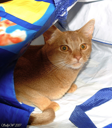

In [ ]:
def torch_2_cv(x):
  x = x.numpy()
  x = np.transpose(x,(1,2,0))
  return x


img_1 = pets_train_Tensor[0]
target_1 = target_train_Tensor[0]

img_1_cv = torch_2_cv(img_1)
img_1_cv = cv2.cvtColor(img_1_cv,cv2.COLOR_BGR2RGB)

cv2_imshow(img_1_cv)

---


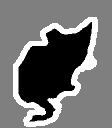

In [ ]:
target_1 = torch.argmax(target_1,dim=0).cpu().detach()
target_1 = target_1.numpy()*(255//2)

print("---")
cv2_imshow(target_1)

---


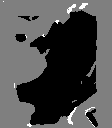

In [ ]:
img_1_net = img_1.reshape((1,img_1.size()[0],img_1.size()[1],img_1.size()[2])).to(device)
pred_1 = unet(img_1_net.to(device))
pred_1 = torch.argmax(pred_1,dim=1).cpu().detach()

pred_1 = torch_2_cv(pred_1)*(255//2)

print("---")
cv2_imshow(pred_1)


O resultado já foi bem melhor que o do Laboratório 7!

Vamos testar com a imagem no seu tamanho original:

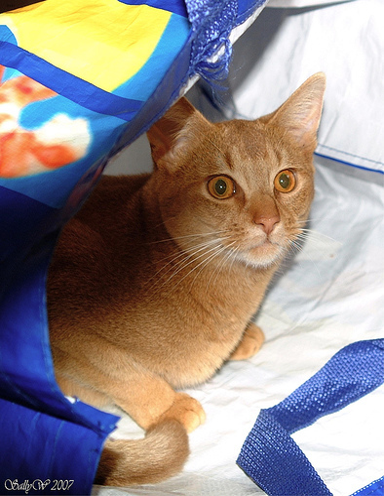

In [ ]:
img_1 = pilToResizedTensor(pets_train_orig[0][0])
target_1 = transformTargets(pets_train_orig[0][1])


#  = pets_train_orig[0]
# target_1 = target_train_Tensor[0]

img_1_cv = torch_2_cv(img_1)
img_1_cv = cv2.cvtColor(img_1_cv,cv2.COLOR_BGR2RGB)

cv2_imshow(img_1_cv)

---


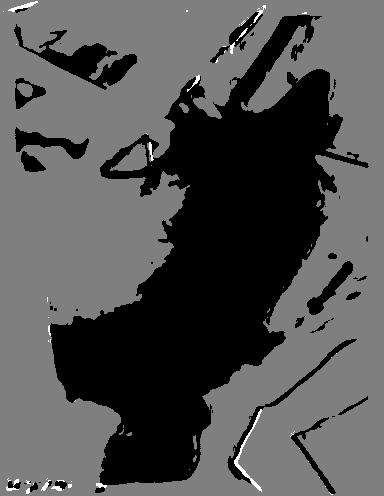

In [ ]:
img_1_net = img_1.reshape((1,img_1.size()[0],img_1.size()[1],img_1.size()[2])).to(device)
pred_1 = unet(img_1_net.to(device))
pred_1 = torch.argmax(pred_1,dim=1).cpu().detach()

pred_1 = torch_2_cv(pred_1)*(255//2)

print("---")
cv2_imshow(pred_1)


Alguns comentários:

Ao contrário do resultado obtido no Lab 7, nós obtivemos:

- Treinamento mais rápido (imagens com menor resolução)
- Rede "aprendendo de fato" - a saída não é só o mesmo número, como se a rede estivesse "chutando".
- Treinamento mais estável, devido ao uso de "batches" com mais de 1 amostra
- Fizemos só 20 iterações e o resultado já foi melhor. Porém, a função de perda do treinamento ainda parece ter uma tendência de queda!
- Por fim, treinamos a rede com imagens menores e ela aparentemente está aprendendo também a distinguir animais em imagens com maior resolução!

Porém, temos um possível problema:

- Quase todas as imagens foram redimensionadas para uma resolução muito menor. Além disso, a razão de aspecto (a razão entre largura e altura) não foi respeitada nas imagens, o que potencialmente inseriu distorções nas imagens.

Mesmo assim, o resultado aparentemente foi bom!

Nos próximos laboratórios, iremos ver as outras técnicas usadas para melhorar o treinamento de redes neurais profundas!